In [1]:
#!pip install snowflake-connector-python[pandas]
#!pip install holidays
#!pip install --upgrade snowflake-sqlalchemy
#!pip install imblearn
#!pip install catboost

import re
import snowflake.connector
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import boto3
import base64
from numpy import dtype, isnan, sqrt
from sqlalchemy import create_engine
from sqlalchemy import pool
from sqlalchemy.dialects import registry
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization
from botocore.exceptions import ClientError
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from dateutil.easter import *
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
import dask.dataframe as dd
import dask
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import catboost
import time


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC
%matplotlib inline

In [ ]:
# loading datasets
df = pd.read_csv('data_dict.csv')
df.head()

In [ ]:
# checking for nulls
df.info()
# dropping cols with sig nulls
df = df.drop(['hashed_email', 'ethnicity', 'postcode', 'aspect_ratio', 'ad_description', 'video_placement'], 1)
df.info()

In [57]:
# grabbing independent vars
X = df[['country', 'gender', 'age', 'brand', 'context_platform', 'session_start_time_label', 'max_height', 'max_width', 'ad_length_seconds', 'is_using_headphones']]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43351 entries, 0 to 43350
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   43321 non-null  object 
 1   gender                    43295 non-null  object 
 2   age                       41543 non-null  float64
 3   brand                     43351 non-null  object 
 4   context_platform          43351 non-null  object 
 5   session_start_time_label  34233 non-null  object 
 6   max_height                43351 non-null  float64
 7   max_width                 43351 non-null  int64  
 8   ad_length_seconds         35619 non-null  float64
 9   is_using_headphones       43351 non-null  bool   
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 3.0+ MB


In [4]:
# Since we do not have that many missing values, I will impute them in a meaningful way
# do not use this right now
X['gender'].fillna(X['gender'].mode()[0], inplace = True)
X['age'].fillna(X['age'].median(), inplace = True)
X['session_start_time_label'].fillna(X['session_start_time_label'].mode()[0], inplace = True)
X['ad_length_seconds'].fillna(X['ad_length_seconds'].median(), inplace = True)
X['is_using_headphones'] = X['is_using_headphones'].round(0).astype(int)
X['max_width'] = X['max_width'].round(0).astype(int)
X['max_height'] = X['max_height'].round(0).astype(int)
X['country'].fillna(X['country'].mode()[0], inplace = True)
X.info()

NameError: name 'X' is not defined

In [20]:
# correlations
# correlation matrix to avoid any potential multicollinearity
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)
corr = X.select_dtypes(exclude=['float'])
corr_vals = corr.apply(lambda x : pd.factorize(x)[0]).corr(method='spearman', min_periods=1)
corr_vals

,country,gender,brand,context_platform,session_start_time_label,max_height,max_width,is_using_headphones
country,1.000000,-0.190423,0.849915,-0.144033,-0.045838,0.743169,0.104583,NaN
gender,-0.190423,1.000000,-0.192947,0.040526,0.005796,-0.155676,0.022928,NaN
brand,0.849915,-0.192947,1.000000,-0.128176,-0.043190,0.767225,0.149101,NaN
context_platform,-0.144033,0.040526,-0.128176,1.000000,0.032352,-0.050770,-0.019355,NaN
session_start_time_label,-0.045838,0.005796,-0.043190,0.032352,1.000000,-0.038496,-0.102644,NaN
max_height,0.743169,-0.155676,0.767225,-0.050770,-0.038496,1.000000,0.170775,NaN
max_width,0.104583,0.022928,0.149101,-0.019355,-0.102644,0.170775,1.000000,NaN
is_using_headphones,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df['ad_time_on_screen_seconds'].value_counts()

30.00     5842
15.00     4963
20.00     4827
12.00     1023
6.00       607
          ... 
42.80        1
364.75       1
377.08       1
201.80       1
254.40       1
Name: ad_time_on_screen_seconds, Length: 1093, dtype: int64

In [58]:
# dif method
def fn (variable) :
    X[variable] = X[variable].fillna(999)
    
    
fn('country')
fn('gender')
fn('age')
fn('brand')
fn('session_start_time_label')
fn('ad_length_seconds')
X['is_using_headphones'] = X['is_using_headphones'].round(0).astype(int)
X['max_width'] = X['max_width'].round(0).astype(int)
X['max_height'] = X['max_height'].round(0).astype(int)
X['max_width'] = X['max_width'].astype(str)
X['max_height'] = X['max_height'].astype(str)
X['height_x_width'] = X['max_height'] + 'X' +  X['max_width']
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43351 entries, 0 to 43350
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   43351 non-null  object 
 1   gender                    43351 non-null  object 
 2   age                       43351 non-null  float64
 3   brand                     43351 non-null  object 
 4   context_platform          43351 non-null  object 
 5   session_start_time_label  43351 non-null  object 
 6   max_height                43351 non-null  object 
 7   max_width                 43351 non-null  object 
 8   ad_length_seconds         43351 non-null  float64
 9   is_using_headphones       43351 non-null  int64  
 10  height_x_width            43351 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.6+ MB



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [66]:
#X = X.drop(['max_height', 'max_width'], 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33479 entries, 0 to 43350
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   33479 non-null  object 
 1   gender                    33479 non-null  object 
 2   age                       33479 non-null  float64
 3   brand                     33479 non-null  object 
 4   context_platform          33479 non-null  object 
 5   session_start_time_label  33479 non-null  object 
 6   ad_length_seconds         33479 non-null  float64
 7   is_using_headphones       33479 non-null  int64  
 8   height_x_width            33479 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.6+ MB


In [ ]:
# Joined DF
joined_df = pd.concat([X, Y], 1)
joined_df.info()

In [71]:
# setting up catboost reg with first dep
Y = df['ad_time_on_screen_seconds']
Y.value_counts()
Y = Y.astype('int')
Y.value_counts()

30     5911
15     5545
20     5010
6      1648
12     1320
       ... 
240       1
144       1
367       1
271       1
399       1
Name: ad_time_on_screen_seconds, Length: 353, dtype: int64

In [115]:
X_train, X_val, Y_train, Y_val = train_test_split(X_new, Y, test_size=0.2, random_state=0, stratify = Y)
X_train.head()

27784    667
30740    375
13541    375
2564     375
28128    896
Name: max_width, dtype: int64

320X568      5978
1080X1920    4576
375X667      4216
375X812      2298
414X896      1996
             ... 
288X320         1
590X320         1
688X375         1
280X320         1
498X724         1
Name: height_x_width, Length: 535, dtype: int64

In [122]:
X_train = X[:30000]
X_val = X[30000:]
Y_train = Y[:30000]
Y_val = Y[30000:]
X_val.head()

,country,gender,age,brand,context_platform,session_start_time_label,max_height,max_width,ad_length_seconds,is_using_headphones
30000,Switzerland,female,19.0,Bauknecht,facebook,morning,667,375,20.0,0
30001,Switzerland,female,19.0,Bauknecht,facebook,morning,667,375,20.0,0
30002,Switzerland,female,19.0,McDonalds,facebook,morning,369,375,30.0,0
30003,Switzerland,female,19.0,McDonalds,facebook,morning,369,375,30.0,0
30004,Switzerland,female,19.0,Nature-Box,facebook,morning,387,375,15.0,0


[0 1 3 4 5 6 7]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'bagging_temperature': 0.05, 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'depth': 8, 'learning_rate': 0.1, 'iterations': 1000}
Best Score:
{'learn': {'MAPE': 1.4076191254256074, 'MAE': 8.173666555243209, 'R2': 0.5857423058233258, 'RMSE': 25.59101416103199, 'NumErrors:greater_than=0.5': 0.864018220513012}, 'validation': {'MAPE': 1.7612144406409893, 'MAE': 10.63854418434781, 'R2': 0.2761078902726144, 'RMSE': 35.463302410992206, 'NumErrors:greater_than=0.5': 0.8684289127837514}}
Best Iteration:
966


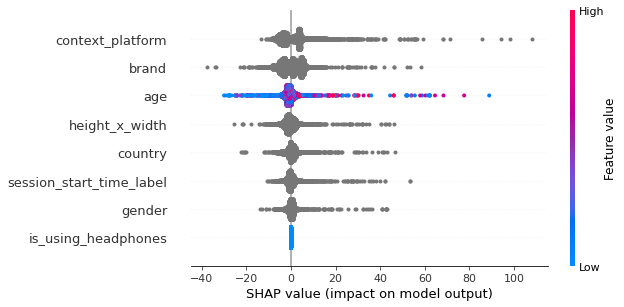

,Feature Id,Importances
0,age,24.491955
1,context_platform,17.405289
2,brand,15.829505
3,height_x_width,11.994156
4,session_start_time_label,11.542413
5,gender,9.626039
6,country,9.110644
7,is_using_headphones,0.000000


In [72]:
#Catboost implementation Regression Method
# Catboost for predicting ad_time_on_screen_seconds
# setting up catboost reg with first dep

import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X_new, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=1000,
                        depth=8,
                        learning_rate=0.1,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [ ]:
# Trying with grid
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
CBC = CatBoostRegressor()    
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.05,0.1,0.5],
                  'iterations'    : [500]
                 }

Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
Grid_CBC.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [101]:
# Next catboost with:
Y = df['ad_time_playing_seconds']

# filling nulls with 0
Y= Y.fillna(0)
Y.value_counts()
Y = Y.astype('int')
Y.value_counts()

30     5962
15     5773
20     5126
1      2763
0      2566
       ... 
51        1
52        1
168       1
53        1
639       1
Name: ad_time_playing_seconds, Length: 81, dtype: int64

In [102]:
#Catboost implementation Regression Method
# Catboost for predicting 'ad_time_playing_seconds'
# setting up catboost reg with first dep
# works well with or without dropping ad length seconds
import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X_new, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=800,
                        depth=8,
                        learning_rate=0.25,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

ValueError: Found input variables with inconsistent numbers of samples: [33479, 33445]

In [51]:
# Next catboost with:
Y = df['ad_time_played_percentage']
# creating specific df to exclude weird vals (over 100 perc)
# filling nulls with 0
Y= Y.fillna(3)
Y.value_counts()
Y = Y.astype('int')

[0 1 3 4 5 7 8]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'bagging_temperature': 0.05, 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'depth': 8, 'learning_rate': 0.2, 'iterations': 500}
Best Score:
{'learn': {'MAPE': 0.7350288385236946, 'MAE': 5.655002850125154, 'R2': 0.9100866935910397, 'RMSE': 11.911819687627233, 'NumErrors:greater_than=0.5': 0.4040622783108688}, 'validation': {'MAPE': 0.9325803220386637, 'MAE': 7.461371808554767, 'R2': 0.8419476628531108, 'RMSE': 15.79979542689676, 'NumErrors:greater_than=0.5': 0.4032258064516129}}
Best Iteration:
289


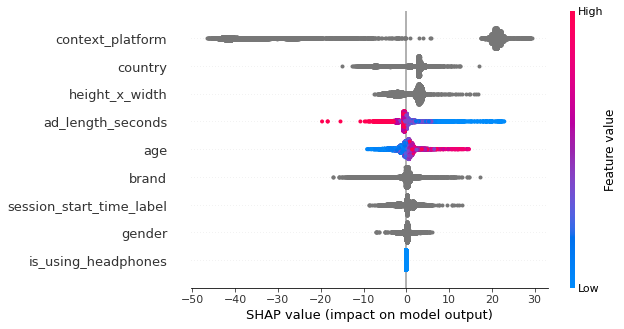

,Feature Id,Importances
0,context_platform,46.007012
1,ad_length_seconds,10.540419
2,age,9.109259
3,brand,8.750908
4,country,8.574979
5,height_x_width,6.383839
6,session_start_time_label,5.584894
7,gender,5.048689
8,is_using_headphones,0.000000


In [75]:
#Catboost implementation Regression Method
# Catboost for predicting 'ad_time_playing_seconds'
# setting up catboost reg with first dep
# works well with or without dropping ad length seconds
import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=500,
                        depth=8,
                        learning_rate=0.2,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [155]:
# Next catboost with: weird vals, need to ask
Y = df['ad_skipped']
# creating specific df to exclude weird vals (over 100 perc)
# filling nulls with 0
Y = Y.fillna(-1)
Y.value_counts()
Y = Y.astype('int')
Y.value_counts()

-1    30170
 1     2077
 0     1232
Name: ad_skipped, dtype: int64

In [99]:
# Next catboost with: weird vals, need to ask
Y = df['attentive_seconds']
# creating specific df to exclude weird vals (over 100 perc)
# filling nulls with 0
Y = Y.fillna(0)
Y.value_counts()
Y = Y.astype('int')
Y.value_counts()

30     4477
15     4471
20     3910
2      3052
0      2388
1      2387
3      1860
4      1268
7      1215
6      1214
12     1134
5       981
10      715
8       621
16      614
9       454
11      411
14      349
13      314
19      220
28      201
17      197
29      170
18      166
31      109
21       98
27       79
26       69
25       58
22       57
24       49
23       47
34       23
42       15
32        9
33        9
36        8
35        4
45        3
48        3
47        2
39        2
40        2
66        1
129       1
37        1
38        1
102       1
53        1
50        1
41        1
49        1
43        1
Name: attentive_seconds, dtype: int64

[0 1 3 4 5 7 8]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'bagging_temperature': 0.05, 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'depth': 10, 'learning_rate': 0.1, 'iterations': 700}
Best Score:
{'learn': {'MAPE': 1.077056430636774, 'MAE': 2.946264141428631, 'R2': 0.791417879252291, 'RMSE': 4.592704621092581, 'NumErrors:greater_than=0.5': 0.84661384362386}, 'validation': {'MAPE': 1.3623669728555834, 'MAE': 3.719244875369292, 'R2': 0.661130529532038, 'RMSE': 5.8080614685978, 'NumErrors:greater_than=0.5': 0.8739721931529376}}
Best Iteration:
693


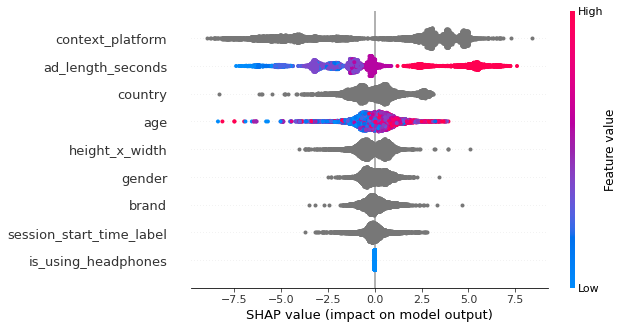

,Feature Id,Importances
0,age,21.228664
1,ad_length_seconds,17.814106
2,context_platform,17.805087
3,height_x_width,9.952387
4,country,9.159353
5,brand,9.053023
6,session_start_time_label,7.950406
7,gender,7.036974
8,is_using_headphones,0.000000


In [100]:
#Catboost implementation Regression Method
# Catboost for predicting attentive seconds
# works well with or without dropping ad length seconds
import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=700,
                        depth=10,
                        learning_rate=0.1,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [92]:
# Creating new df
df.drop(df[df['active_attentive_seconds'] >= 33].index, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33445 entries, 0 to 43350
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   group_id                           33445 non-null  object 
 1   user_id                            33445 non-null  object 
 2   age                                32274 non-null  float64
 3   gender                             33402 non-null  object 
 4   country                            33415 non-null  object 
 5   brand                              33445 non-null  object 
 6   context_platform                   33445 non-null  object 
 7   ad_type                            33445 non-null  object 
 8   session_start_time                 26495 non-null  float64
 9   session_start_time_label           26495 non-null  object 
 10  max_height                         33445 non-null  float64
 11  max_width                          33445 non-null  int

In [96]:
# Next catboost with: weird vals, need to ask
Y = df['active_attentive_seconds']
# creating specific df to exclude weird vals (over 100 perc)
# filling nulls with 0
Y = Y.fillna(0)
Y.value_counts()
Y = Y.astype('int')
Y.value_counts() > 5

0     True
1     True
2     True
3     True
15    True
4     True
20    True
30    True
5     True
6     True
7     True
12    True
10    True
8     True
14    True
11    True
13    True
9     True
19    True
16    True
17    True
18    True
29    True
28    True
27    True
26    True
25    True
24    True
22    True
21    True
23    True
32    True
31    True
Name: active_attentive_seconds, dtype: bool

In [98]:
X = X.drop(['max_height', 'max_width'], 1)

[ 0  1  3  4  5  6  7  9 10]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'bagging_temperature': 0.05, 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'depth': 10, 'learning_rate': 0.5, 'iterations': 700}
Best Score:
{'learn': {'MAPE': 0.854351864534052, 'MAE': 1.8784344401483404, 'R2': 0.8697804532758423, 'RMSE': 2.9962836481009663, 'NumErrors:greater_than=0.5': 0.701338017640903}, 'validation': {'MAPE': 1.975256978336986, 'MAE': 4.454961453504513, 'R2': 0.4276320005484142, 'RMSE': 6.240177757339017, 'NumErrors:greater_than=0.5': 0.8817461503961728}}
Best Iteration:
92


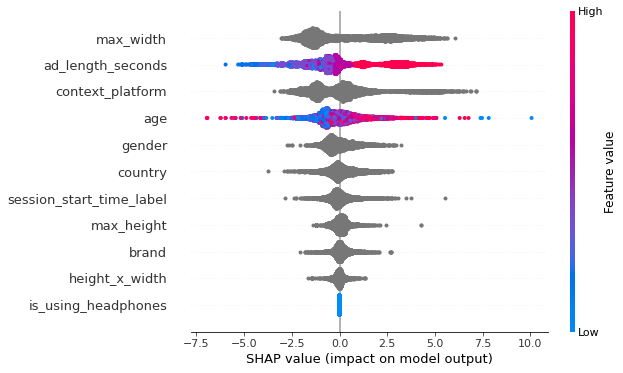

,Feature Id,Importances
0,age,29.116462
1,ad_length_seconds,11.398679
2,max_width,10.840714
3,context_platform,10.177023
4,gender,10.093721
5,session_start_time_label,8.903243
6,country,8.256175
7,brand,5.796099
8,max_height,3.758077
9,height_x_width,1.659807


In [97]:
#Catboost implementation Regression Method
# Catboost for predicting active attentive seconds
# works well with or without dropping ad length seconds
import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=700,
                        depth=10,
                        learning_rate=0.5,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [ ]:
X['context_platform'].info()

In [53]:
## Focusing only on add_played_percentage
Y.loc[Y > 70] = 100
Y.loc[Y == 0] = 1
Y.value_counts()

100    24266
3       8317
1        873
2        536
4        527
6        525
5        522
7        437
8        422
9        355
10       300
11       299
12       284
13       244
19       233
14       228
15       220
17       219
18       206
16       200
20       198
28       198
27       179
29       178
21       170
23       148
30       138
24       133
22       132
36       131
37       130
32       126
25       123
31       122
35       110
33       109
26       108
38       101
40        95
34        89
42        87
39        87
44        73
41        67
50        65
47        60
48        59
45        59
46        58
43        58
51        56
49        50
55        48
54        46
53        44
57        43
52        41
58        39
61        38
65        35
60        34
59        33
64        33
69        30
56        28
63        28
62        27
68        25
66        25
67        22
70        22
Name: ad_time_played_percentage, dtype: int64

In [9]:
pd.set_option("display.max_rows", None)
df = df[(df['ad_time_played_percentage'] > 90) | (df['ad_time_played_percentage'] < 70)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35176 entries, 0 to 43350
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   group_id                           35176 non-null  object 
 1   user_id                            35176 non-null  object 
 2   age                                33957 non-null  float64
 3   gender                             35127 non-null  object 
 4   country                            35146 non-null  object 
 5   brand                              35176 non-null  object 
 6   context_platform                   35176 non-null  object 
 7   ad_type                            35176 non-null  object 
 8   session_start_time                 28159 non-null  float64
 9   session_start_time_label           28159 non-null  object 
 10  max_height                         35176 non-null  float64
 11  max_width                          35176 non-null  int

In [54]:
bins= [0,5,13,50,101]
Y = pd.cut(Y, bins=bins, right=False)
Y.value_counts()

[0, 5)       10253
[13, 50)      4926
[5, 13)       3144
[50, 100)      762
Name: ad_time_played_percentage, dtype: int64

In [19]:
X = X.drop(['max_height', 'max_width'], 1)

KeyError: "['max_height' 'max_width'] not found in axis"

[ 0  1  3  4  5  6  7  9 10]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'bagging_temperature': 0.05, 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'loss_function': 'RMSE', 'depth': 8, 'learning_rate': 0.1, 'iterations': 1000}
Best Score:
{'learn': {'MAPE': 0.12477083388115574, 'MAE': 0.31042842447792396, 'R2': 0.91277711403256, 'RMSE': 0.6556028271425327, 'NumErrors:greater_than=0.5': 0.2064878892733564}, 'validation': {'MAPE': 0.17607604665696847, 'MAE': 0.41572717144222926, 'R2': 0.8439691749193392, 'RMSE': 0.8798609076852939, 'NumErrors:greater_than=0.5': 0.24380117633490947}}
Best Iteration:
973


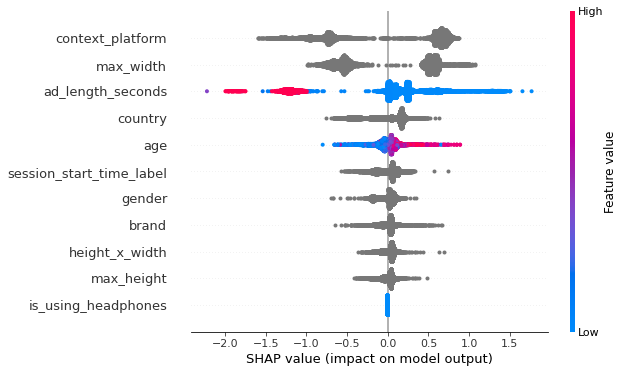

,Feature Id,Importances
0,ad_length_seconds,21.985095
1,context_platform,18.745470
2,age,10.979796
3,brand,9.804226
4,max_width,9.538002
5,country,7.014974
6,session_start_time_label,6.941684
7,max_height,6.941466
8,height_x_width,4.186485
9,gender,3.862804


In [44]:
#Catboost implementation Regression Method
# Catboost for predicting 'ad_time_playing_seconds'
# setting up catboost reg with first dep
# works well with or without dropping ad length seconds
import seaborn as sns
import shap
from catboost import CatBoostRegressor

#CatBoostRegressor(loss_function='Tweedie:variance_power=2', n_estimators=500, silent=True)
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.2, random_state=0)

categorical_features_indices = np.where(Xdata_train.dtypes != np.float)[0]
print(categorical_features_indices)
model=CatBoostRegressor(iterations=1000,
                        depth=8,
                        learning_rate=0.1,
                        bagging_temperature = 0.05,
                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                        #per_float_feature_quantization='3:border_count=1024',
                        loss_function='RMSE',)
model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), use_best_model = True,plot=True,verbose=False)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())
#Analysis of shap features
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices),
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])
shap.summary_plot(shap_values, Xdata_val)
##Feature importance
model.get_feature_importance(prettified=True)

In [126]:
# SMOTE STEP
#List all of your categorical columns here
category_cols = ['context_platform', 'height_x_width', 'brand', 'country', 'session_start_time_label']
# initilize oversamplers
smote = SMOTE(random_state=42)
X_smote = X
Y_smote = Y
X_smote.info()
from imblearn.over_sampling import SMOTENC
categorical_features_indices = np.where(X_smote.dtypes != np.float)[0]
print(categorical_features_indices)
X_train_smote, X_val_smote, Y_train_smote, Y_val_smote = train_test_split(X_smote, Y_smote, test_size=0.2, random_state=0 )
sm = SMOTENC(categorical_features= categorical_features_indices,
             random_state=0,
             sampling_strategy = {10: .1, 20: .1, 30: .1, 40: .1, 50: .1, 60: .1, 70: .1, 80: .1, 90: .1, 100: .1},
             k_neighbors=1)
X_train_smote, Y_train_smote = sm.fit_resample(X_smote, Y_smote)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43351 entries, 0 to 43350
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   43351 non-null  object 
 1   gender                    43351 non-null  object 
 2   age                       43351 non-null  float64
 3   brand                     43351 non-null  object 
 4   context_platform          43351 non-null  object 
 5   session_start_time_label  43351 non-null  object 
 6   ad_length_seconds         43351 non-null  float64
 7   is_using_headphones       43351 non-null  int64  
 8   height_x_width            43351 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.0+ MB
[0 1 3 4 5 7 8]


ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 300 samples and 0.1 samples are asked.

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43351 entries, 0 to 43350
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   43351 non-null  object 
 1   gender                    43351 non-null  object 
 2   age                       43351 non-null  float64
 3   brand                     43351 non-null  object 
 4   context_platform          43351 non-null  object 
 5   session_start_time_label  43351 non-null  object 
 6   max_height                43351 non-null  object 
 7   max_width                 43351 non-null  object 
 8   ad_length_seconds         43351 non-null  float64
 9   is_using_headphones       43351 non-null  int64  
 10  height_x_width            43351 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 3.6+ MB


In [59]:
## multiclass regression
# Second iteration of catboost
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)

# Model with sheet variables

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
print(categorical_features_indices)

clf = CatBoostClassifier(
    iterations=800,
    random_strength = 0.5,
    class_weights = [0.3,0.7],
    custom_metric=['F1', 'Accuracy', 'Precision', 'Recall'],
    
    l2_leaf_reg = 7, # controls the gradient boosting, similar to regularization penalty
    learning_rate=.2, 
    loss_function='MultiClass'
)

clf.fit(X_train, Y_train, 
        cat_features=categorical_features_indices, 
        eval_set=(X_val, Y_val),
        use_best_model=True,
        plot = True, 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

print('Best Score:')
print(clf.get_best_score())

print('Best Iteration:')
print(clf.get_best_iteration())


#Shap features and feature importance
import shap
shap_values = clf.get_feature_importance(Pool(X_val, label=Y_val,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_val.iloc[3,:])

shap.summary_plot(shap_values, X_val)
##Feature importance
clf.get_feature_importance(prettified=True)

ValueError: Input contains NaN